# Real estate ROI calculator 

## Configurables
Change your url and location here

In [5]:
#Replace this url with the url of your search results
#url = 'https://www.immobilienscout24.de/Suche/de/berlin/berlin/wohnung-kaufen?enteredFrom=one_step_search'
# TODO concatenate url with region and city
# state = "sachsen-anhalt"
# city = "magdeburg"
url_to_crawl = 'https://www.immobilienscout24.de/Suche/de/sachsen-anhalt/magdeburg/wohnung-kaufen?enteredFrom=one_step_search'
file_name_csv_raw = 'immobilienscout_result.csv'

# Your variables to change
rent_price_index = 11
equity_percentage = 0.2
interest_rate = 0.01
mortgage_payment_rate = 0.02

# Standard percentages
notary_percentage = 0.015
transfer_tax_percentage = 0.05
land_registry_tax_percentage = 0.005
additional_costs_rate_per_m2 = 0.9 

## Setup

In [12]:
import urllib.request
import scrapy
from scrapy.crawler import CrawlerProcess
from scrapy import Selector
import selenium
from selenium import webdriver
import chromedriver_binary
from webdriver_manager.chrome import ChromeDriverManager
from selenium.webdriver.chrome.options import Options
import pandas as pd
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_colwidth', 200)

import json
import re
import numpy as np

from matplotlib import pyplot as plt
%matplotlib inline

import seaborn as sns

2020-07-19 13:43:12 [matplotlib.pyplot] DEBUG: Loaded backend module://ipykernel.pylab.backend_inline version unknown.


In [2]:

columns = ['id_expose', 'url', 'title', 'address', 'contact_person', 'telephone', 'mobile', 'fax', 'price_purchase', 'estimated_monthly_rate', 'rooms', 'living_area_m2', 'furnishing', 'flat_type', 'floor', 'floor_total', 'bedrooms', 'commission_buyer_rate', 'maintenance_cost', 'construction_year', 'object_state', 'heating_type', 'energy_efficiency_class', 'location']

df_base = pd.DataFrame(columns = columns)

options = Options()
options.headless = True

crawler_name = 'scrapper_immobilienscout'

base_uri = 'immobilienscout24.de'
base_url = 'https://www.immobilienscout24.de'

In [3]:
driver = webdriver.Chrome()
# OLD configuration
#driver = webdriver.Chrome(options=options, executable_path="chromedriver.exe")

class Scrap_immobilienscout(scrapy.Spider):
    
    name = crawler_name
    
    def start_requests(self):
        first_page = urllib.request.urlopen(url_to_crawl)
        max_pages = first_page.read()
        max_pages = max_pages.decode("utf8")
        first_page.close()

        max_pages_selector = Selector(text = max_pages)
        max_pages = max_pages_selector.xpath('//select[@aria-label="Seitenauswahl"]/option[last()]/@value').extract_first()
        max_pages = int(max_pages) if max_pages is not None else 1
        
        base_url = url_to_crawl.replace('enteredFrom=one_step_search', '')
        
        for page_number in range(max_pages):
            url = base_url + 'pagenumber=' + str(page_number + 1)
            yield scrapy.Request(url, callback = self.parse_properties_list)
    
    def parse_properties_list(self, response):
        
        property_urls = response.xpath('//a[contains(@class, "result-list-entry__brand-title-container")]/@href').extract()
        
        for url in property_urls:
            if base_uri not in url:
                url = base_url + url + '#/'
                driver.get(url)
                src = driver.page_source
                self.scrap_property(src, url)
    
    # TODO rename variables
    # TODO clarify default values
    # TODO fix parse issues (int, roundings, etc.)
    def scrap_property(self, src, url):
        sel = Selector(text = src)

        id_expose = '' # TODO get expose substring of url
        
        title = sel.css('h1#expose-title ::text').extract_first()
        
        address = sel.xpath('//div[@class="address-block"]//span[@class="block font-nowrap print-hide"]//text()').extract_first()
        address = address.strip() if address is not None else ''

        region = sel.css('span.zip-region-and-country::text').extract_first()
        address += ' ' + region if region is not None else ''
        
        contact_person = sel.xpath('//div[@data-qa="contactName"]//text()').extract_first()
        contact_person = contact_person if contact_person is not None else ''
        
        phone = sel.xpath('//script//text()').extract_first()
        phone = phone if phone is not None else ''

        telefon = re.findall('"phoneNumber":\{"contactNumber":"(\+?[0-9 ]*)"\}', phone)
        telefon = telefon[0].replace(' ', '') if len(telefon) > 0 else None
        
        mobil = re.findall('"cellPhoneNumber":\{"contactNumber":"(\+?[0-9 ]*)"\}', phone)
        mobil = mobil[0] if len(mobil) > 0 else ''
        mobil = mobil.replace(' ', '')

        fax = re.findall('"faxNumber":\{"contactNumber":"(\+?[0-9 ]*)"\}', phone)
        fax = fax[0] if len(fax) > 0 else ''
        fax = fax.replace(' ', '')
        
        price = sel.xpath('//dd[contains(@class, "is24qa-kaufpreis")]//text()').extract_first()
        price = re.sub('[^0-9]', '', price) if price is not None else 0
        price = int(price)
        
        estimated_monthly_rate = sel.xpath('//span[contains(@class, "monthly-rate-result") and contains(@class, "monthly-rate-value")]//text()').extract_first()
        estimated_monthly_rate = re.sub('[^0-9]', '', monthly_rate) if monthly_rate is not None else 0
        estimated_monthly_rate = int(monthly_rate)
        
        rooms_count = sel.xpath('//dd[contains(@class,"is24qa-zimmer")]/text()').extract_first()
        rooms_count = float(rooms_count.replace(" ","").replace(",",".") ) if rooms_count is not None else 0
        
        living_area = sel.xpath('//dd[contains(@class, "is24qa-wohnflaeche-ca")]/text()').extract_first()
        living_area = re.sub('[^0-9]', '', living_area.replace(",",".")) if living_area is not None else 0
        living_area = float(living_area)
        
        furnishing = sel.xpath('//div[contains(@class, "criteriagroup") and contains(@class, "boolean-listing")]//span[contains(@class, "palm-hide")]/text()').extract()
        furnishing = list(set(furnishing))
        furnishing = [t for t in furnishing if t != ' ']
        furnishing = furnishing if len(furnishing) > 0 else ''
        
        flat_type = sel.xpath('//dd[contains(@class, "is24qa-typ")]/text()').extract_first()
        
        floor = sel.xpath('//dd[contains(@class, "is24qa-etage")]//text()').extract_first()
        floor = floor if floor is not None else ''
        floor = re.findall('[0-9]+', floor)
        total_floors = int(floor[1]) if len(floor) > 1 else 0
        floor = int(floor[0]) if len(floor) > 0 else 0
        
        bedroom = sel.xpath('//dd[contains(@class, "is24qa-schlafzimmer")]//text()').extract_first()
        bedroom = re.sub('[^0-9]', '', bedroom) if bedroom is not None else 0
        bedroom = int(bedroom)
        
        allowance = sel.xpath('//dd[contains(@class, "is24qa-hausgeld")]//text()').extract_first()
        allowance = re.sub('[^0-9]', '', allowance) if allowance is not None else 0
        allowance = int(allowance)
        
        commission = sel.xpath('//dd[contains(@class, "is24qa-provision")]/text()').extract_first()
        
        if commission is not None:
            try:
                commission = re.search('[0-9]+,?[0-9]*', commission).group() 
            except:
                commission = ''
        else:
            ''

        commission = commission.replace(',', '.')
        commission = float(commission) if len(commission) > 0 else 0
        
        construction_year = sel.xpath('//dd[contains(@class, "is24qa-baujahr")]//text()').extract_first()
        
        object_state = sel.xpath('//dd[contains(@class, "is24qa-objektzustand")]//text()').extract_first()
        
        heatingy_type = sel.xpath('//dd[contains(@class, "is24qa-heizungsart")]//text()').extract_first()
        
        energy_efficiency_class = sel.xpath('//dd[contains(@class, "is24qa-energieeffizienzklasse")]//text()').extract_first()
        energy_efficiency_class = energy_efficiency_class if energy_efficiency_class is not None else ''
        
        location = sel.xpath('//pre[contains(@class, "is24qa-lage")]/text()').extract_first()

        lst_row = [id_expose, url, title, address, contact_person, telefon, mobil, fax, price, estimated_monthly_rate, rooms_count, living_area, furnishing, flat_type, floor, total_floors, bedroom, commission, allowance, construction_year, object_state, heatingy_type, energy_efficiency_class, location]
        df_base.loc[len(df_base)] = lst_row
        df_base.to_csv(file_name_csv_raw, index=False)
        
process = CrawlerProcess()
process.crawl(Scrap_immobilienscout)
process.start()
# TODO unblock process. See: https://docs.scrapy.org/en/latest/topics/practices.html 

2020-07-19 13:42:19 [scrapy.utils.log] INFO: Scrapy 2.2.0 started (bot: scrapybot)
2020-07-19 13:42:19 [scrapy.utils.log] INFO: Versions: lxml 4.5.2.0, libxml2 2.9.10, cssselect 1.1.0, parsel 1.6.0, w3lib 1.22.0, Twisted 20.3.0, Python 3.7.4 (default, Sep  7 2019, 18:27:02) - [Clang 10.0.1 (clang-1001.0.46.4)], pyOpenSSL 19.1.0 (OpenSSL 1.1.1g  21 Apr 2020), cryptography 2.9.2, Platform Darwin-18.7.0-x86_64-i386-64bit
2020-07-19 13:42:19 [scrapy.utils.log] DEBUG: Using reactor: twisted.internet.selectreactor.SelectReactor
2020-07-19 13:42:19 [scrapy.crawler] INFO: Overridden settings:
{}
2020-07-19 13:42:19 [scrapy.extensions.telnet] INFO: Telnet Password: b89e4b4841a16f04
2020-07-19 13:42:19 [scrapy.middleware] INFO: Enabled extensions:
['scrapy.extensions.corestats.CoreStats',
 'scrapy.extensions.telnet.TelnetConsole',
 'scrapy.extensions.memusage.MemoryUsage',
 'scrapy.extensions.logstats.LogStats']
2020-07-19 13:42:19 [scrapy.middleware] INFO: Enabled downloader middlewares:
['scra

In [5]:
# Write (parse) to CSV again
df_base.to_csv(file_name_csv_raw, index=False)

In [7]:
# Read CSV again
df_base = pd.read_csv(file_name_csv_raw)

## Exploration

In [8]:
# dataframe dimensions
df_base.shape

(84, 24)

In [9]:
# column datatypes
df_base.dtypes

id_expose                  float64
url                        object 
title                      object 
address                    object 
contact_person             object 
telephone                  float64
mobile                     float64
fax                        float64
price_purchase             int64  
estimated_monthly_rate     int64  
rooms                      float64
living_area_m2             int64  
tags                       object 
type                       object 
floor                      int64  
floor_total                int64  
bedrooms                   int64  
commission_buyer_rate      float64
maintenance_cost           int64  
construction_year          object 
object_state               object 
heating_type               object 
energy_efficiency_class    object 
location                   object 
dtype: object

In [10]:
df_base.select_dtypes(include=['object']).isnull().sum()

url                        0 
title                      0 
address                    0 
contact_person             36
tags                       4 
type                       5 
construction_year          9 
object_state               30
heating_type               9 
energy_efficiency_class    61
location                   17
dtype: int64

In [13]:
df_base.head(10)
#df_base['url'][4]
#df[0:5]
#df.tail()

,id_expose,url,title,address,contact_person,telephone,mobile,fax,price_purchase,estimated_monthly_rate,rooms,living_area_m2,tags,type,floor,floor_total,bedrooms,commission_buyer_rate,maintenance_cost,construction_year,object_state,heating_type,energy_efficiency_class,location
0,NaN,https://www.immobilienscout24.de/expose/120741119#/,*** Investoren Aufgepasst *** Charmante 2 Zimmer Wohnung in Stadtfeld Ost,"39108 Magdeburg, Stadtfeld Ost",Herr M. Azzaro,NaN,1.515430e+10,3.036289e+09,69000,0,2.0,5115,"['Vermietet', 'Balkon/ Terrasse']",Erdgeschosswohnung,0,0,0,7000.00,20669,1900,NaN,Zentralheizung,NaN,"Die Olvenstedter Straße befindet sich im Stadtteil Stadtfeld-Ost. Die öffentlichen Verkehrsmittel befinden sich direkt vor der Haustür. Der Bahnhof, sowie der zentrale Omnibusbahnhof sind ca. 10-1..."
1,NaN,https://www.immobilienscout24.de/expose/120493905#/,Sanierte 3 Zimmer-Wohnung mit hochwertiger Einbauküche in tollem Altbau!,"Heydeckstr. 12, 39104 Magdeburg / Altstadt, Magdeburg",NaN,3.915847e+10,1.711772e+09,3.915847e+10,275000,0,3.0,100,"['Stufenloser Zugang', 'Einbauküche', 'Personenaufzug', 'Keller']",Etagenwohnung,3,4,2,5.95,290,1900,Saniert,Zentralheizung,NaN,"Der Stadtteil Mitte/ Altstadt liegt im Zentrum Magdeburgs. Die Altstadt ist heute im nördlichen Teil von Plattenbauten und Geschäftshäusern geprägt, in der Mitte von Einkaufszentren und öffentlich..."
2,NaN,https://www.immobilienscout24.de/expose/120330827#/,*** vermietete Eigentumswohnung *** 4 Zimmer mit Terrasse und Stellplatz in Stadtfeld West,"39110 Magdeburg, Stadtfeld West",Herr M. Azzaro,NaN,1.515430e+10,3.036289e+09,135000,0,4.0,10701,"['Vermietet', 'Einbauküche', 'Balkon/ Terrasse', 'Keller']",Dachgeschoss,3,3,0,12000.00,37261,1912,NaN,Zentralheizung,NaN,"Stadtfeld-Ost\nDer Stadtteil erfreut sich größter Beliebtheit. Hier gibt es reichlich Einkaufsmöglichkeiten, Bildungseinrichtungen aller Schulformen, Krippen und Kindergärten sowie Jugend- und Sen..."
3,NaN,https://www.immobilienscout24.de/expose/120056983#/,*** vermietete Eigentumswohnung *** 2 Zimmer mit Balkon und Stellplatz in Stadtfeld West,"39110 Magdeburg, Stadtfeld West",NaN,NaN,1.515430e+10,3.036289e+09,62500,0,2.0,4976,"['Einbauküche', 'Balkon/ Terrasse']",Erdgeschosswohnung,1,3,0,6000.00,18986,1912,NaN,Zentralheizung,NaN,"Stadtfeld-West\nDer Stadtteil erfreut sich größter Beliebtheit. Hier gibt es reichlich Einkaufsmöglichkeiten, Bildungseinrichtungen aller Schulformen, Krippen und Kindergärten sowie Jugend- und Se..."
4,NaN,https://www.immobilienscout24.de/expose/119494914#/,*** vermietete Eigentumswohnung *** 1 Zimmer mit Terrasse und Stellplatz in Stadtfeld West,"39110 Magdeburg, Stadtfeld West",NaN,NaN,1.515430e+10,3.036289e+09,49900,0,1.0,4001,"['Vermietet', 'Einbauküche', 'Balkon/ Terrasse']",Erdgeschosswohnung,0,3,0,6000.00,15240,1912,NaN,Zentralheizung,NaN,"Stadtfeld-West\nDer Stadtteil erfreut sich größter Beliebtheit. Hier gibt es reichlich Einkaufsmöglichkeiten, Bildungseinrichtungen aller Schulformen, Krippen und Kindergärten sowie Jugend- und Se..."
5,NaN,https://www.immobilienscout24.de/expose/119494902#/,*** bezugsfreie Eigentumswohnung *** 1 Zimmer mit Balkon und Stellplatz in Stadtfeld West,"39110 Magdeburg, Stadtfeld West",Herr M. Azzaro,NaN,1.515430e+10,3.036289e+09,55000,0,1.0,4756,"['Einbauküche', 'Balkon/ Terrasse', 'Keller']",Etagenwohnung,2,3,0,6000.00,18368,1912,NaN,Zentralheizung,NaN,"Stadtfeld-West\nDer Stadtteil erfreut sich größter Beliebtheit. Hier gibt es reichlich Einkaufsmöglichkeiten, Bildungseinrichtungen aller Schulformen, Krippen und Kindergärten sowie Jugend- und Se..."
6,NaN,https://www.immobilienscout24.de/expose/119368847#/,Günstige Eigentumswohnung,"39112 Magdeburg, Sudenburg",NaN,3.405338e+08,1.798603e+09,NaN,75000,0,2.0,45,['Einbauküche'],NaN,1,0,1,7.14,142,1900,Vollständig renoviert,Zentralheizung,NaN,"Die Wohnung befindet sich im Stadtteil Sudenburg mit sehr guter Infrastruktur.\nVerkehrsanbindung, Einkaufsmöglichkeiten in unmittelbarer Nähe, Einr

In [14]:
# TODO transform into numerical values for historgrams
# df_base.hist(xrot=-45, figsize=(14,14))

In [15]:
df_base.describe()

,rooms,commission_buyer_rate
count,84.000000,84.000000
mean,2.613095,545.720833
std,1.079243,1943.523837
min,1.000000,0.000000
25%,2.000000,0.000000
50%,2.750000,3.240000
75%,3.000000,5.950000
max,6.000000,12000.000000


In [16]:
df_base.describe(include='object')

,id_expose,url,title,address,contact_person,telephone,mobile,fax,price_purchase,estimated_monthly_rate,living_area_m2,tags,type,floor,floor_total,bedrooms,maintenance_cost,construction_year,object_state,heating_type,energy_efficiency_class,location
count,84,84,84,84,48,73,84,84,84,84,84,84,79,84,84,84,84,75,54,75,23,67
unique,1,84,79,41,28,34,29,24,68,1,74,53,8,5,5,6,42,32,8,6,7,56
top,,https://www.immobilienscout24.de/expose/119368...,Vermietete Eigentumswohnung in Magdeburg Stadt...,"39108 Magdeburg, Stadtfeld Ost",Herr Sascha Schümann,3916229382,,,135000,0,371,"[Stufenloser Zugang, Keller, Provisionsfrei, P...",Etagenwohnung,0,0,0,0,1900,Gepflegt,Zentralheizung,A,Sehr gute Lage in unmittelbarer Nähe zum Zentr...
freq,84,1,2,9,4,7,26,31,3,84,4,6,46,34,38,32,42,10,18,53,7,4


2:57:23 [matplotlib.font_manager] DEBUG: findfont: score(<Font 'Arial Unicode MS' (Arial Unicode.ttf) normal normal 400 normal>) = 10.05
2020-07-19 12:57:23 [matplotlib.font_manager] DEBUG: findfont: score(<Font 'Devanagari MT' (DevanagariMT.ttc) normal normal 400 normal>) = 10.05
2020-07-19 12:57:23 [matplotlib.font_manager] DEBUG: findfont: score(<Font '.SF Compact Display' (SFCompactDisplay-Medium.otf) normal normal 500 normal>) = 10.145
2020-07-19 12:57:23 [matplotlib.font_manager] DEBUG: findfont: score(<Font 'Khmer MN' (Khmer MN.ttc) normal normal 400 normal>) = 10.05
2020-07-19 12:57:23 [matplotlib.font_manager] DEBUG: findfont: score(<Font 'PT Serif Caption' (PTSerifCaption.ttc) normal normal 400 normal>) = 10.05
2020-07-19 12:57:23 [matplotlib.font_manager] DEBUG: findfont: score(<Font 'Bangla Sangam MN' (Bangla Sangam MN.ttc) normal normal 400 normal>) = 10.05
2020-07-19 12:57:23 [matplotlib.font_manager] DEBUG: findfont: score(<Font 'Chalkduster' (Chalkduster.ttf) normal nor

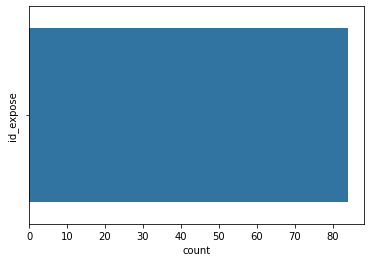

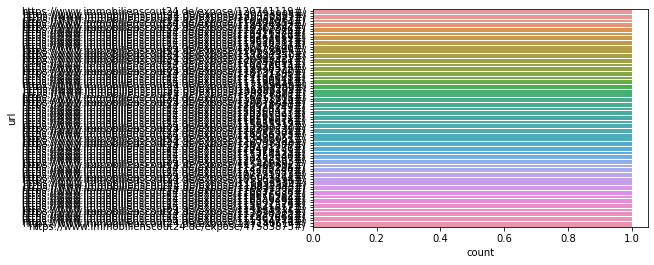

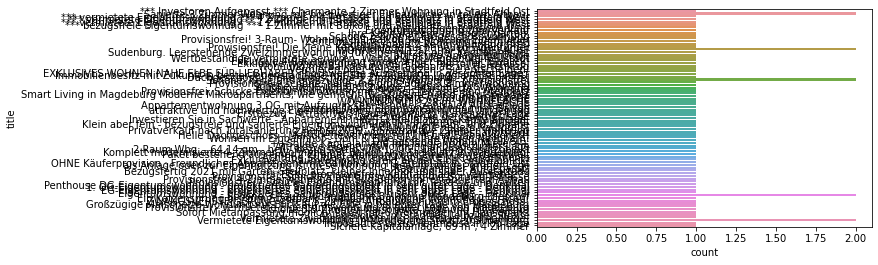

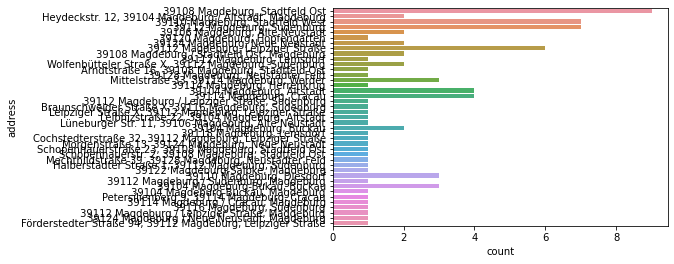

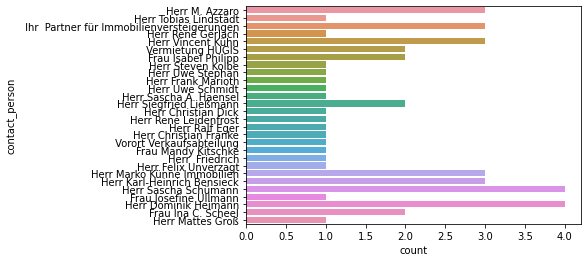

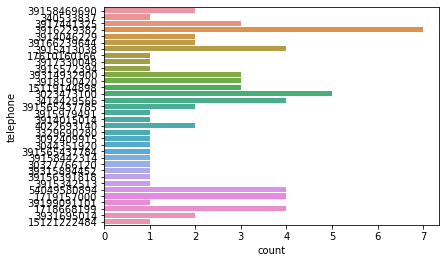

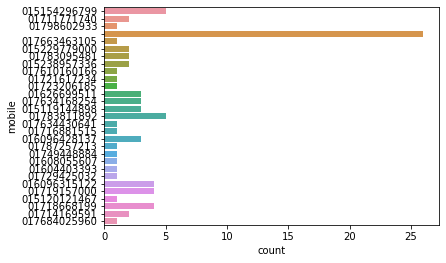

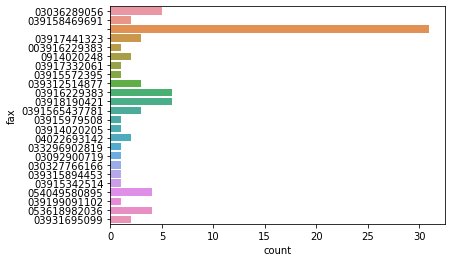

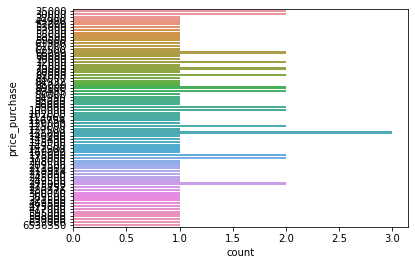

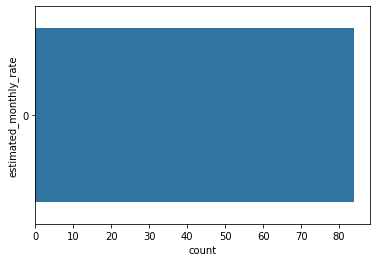

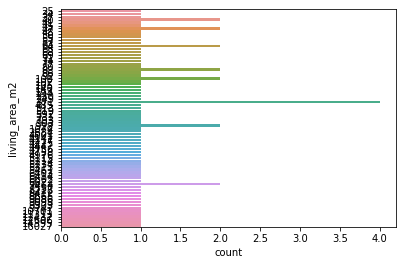

TypeError: unhashable type: 'list'

In [17]:
# TODO fix usage of list
# TODO data needs to be fixed
for features in df_base.dtypes[df_base.dtypes == 'object'].index:
    sns.countplot(y=features, data=df_base)
    plt.show()

## Data argmentation
Goal is to calculate the yearly ROI

In [24]:
df_finance = df_base[['url','price_purchase', 'commission_buyer_rate']]
df_finance['notary_costs'] = notary_percentage * df_base['price_purchase']

df_finance['land_registry_tax'] = land_registry_tax_percentage * df_base['price_purchase']
df_finance['real_estate_transfer_tax'] = transfer_tax_percentage * df_base['price_purchase']
df_finance['commission'] = df_finance['price_purchase'] * df_finance['commission_buyer_rate'] * 0.01 # TODO fix while parsing from scraper already
df_finance['total_buying_price'] = df_finance['price_purchase'] + df_finance['notary_costs'] + df_finance['land_registry_tax'] + df_finance['real_estate_transfer_tax'] + df_finance['commission']
df_finance['equity'] = equity_percentage * df_finance['total_buying_price']
df_finance['debt'] = df_finance['total_buying_price'] - df_finance['equity']
df_finance['interest_rate_monthly'] = interest_rate * df_finance['debt'] / 12
df_finance['mortgage_payment'] = mortgage_payment_rate * df_finance['debt']
df_finance['monthly_rent'] = rent_price_index * df_base['living_area_m2']
df_finance['additional_costs'] = additional_costs_rate_per_m2 * df_base['living_area_m2']
df_finance['cashflow'] = df_finance['monthly_rent'] - df_finance['interest_rate_monthly'] - df_finance['mortgage_payment'] - df_finance['additional_costs']
df_finance['ROI'] = (df_finance['cashflow'] * 12) / df_finance['equity'] 





In [25]:
df_finance

,url,price_purchase,commission_buyer_rate,notary_costs,land_registry_tax,real_estate_transfer_tax,commission,total_buying_price,equity,debt,interest_rate_monthly,mortgage_payment,monthly_rent,additional_costs,cashflow,ROI
0,https://www.immobilienscout24.de/expose/120741...,69000,7000.00,1035,345,3450,4.83e+06,4.90383e+06,980766,3.92306e+06,3269.22,78461.3,56265,4603.5,-30069,-0.367904
1,https://www.immobilienscout24.de/expose/120493...,275000,5.95,4125,1375,13750,16362.5,310612,62122.5,248490,207.075,4969.8,1100,90,-4166.88,-0.804902
2,https://www.immobilienscout24.de/expose/120330...,135000,12000.00,2025,675,6750,1.62e+07,1.63444e+07,3.26889e+06,1.30756e+07,10896.3,261511,117711,9630.9,-164327,-0.603241
3,https://www.immobilienscout24.de/expose/120056...,62500,6000.00,937.5,312.5,3125,3.75e+06,3.81688e+06,763375,3.0535e+06,2544.58,61070,54736,4478.4,-13357,-0.209967
4,https://www.immobilienscout24.de/expose/119494...,49900,6000.00,748.5,249.5,2495,2.994e+06,3.04739e+06,609479,2.43791e+06,2031.6,48758.3,44011,3600.9,-10379.8,-0.204367
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79,https://www.immobilienscout24.de/expose/112827...,61900,0.00,928.5,309.5,3095,0,66233,13246.6,52986.4,44.1553,1059.73,48917,4002.3,43810.8,39.6879
80,https://www.immobilienscout24.de/expose/111402...,30000,0.00,450,150,1500,0,32100,6420,25680,21.4,513.6,4081,333.9,3212.1,6.00393
81,https://www.immobilienscout24.de/expose/111354...,30000,0.00,450,150,1500,0,32100,6420,25680,21.4,513.6,4081,333.9,3212.1,6.00393
82,https://www.immobilienscout24.de/expose/107140...,595000,0.00,8925,2975,29750,0,636650,127330,509320,424.433,10186.4,2134,174.6,-8651.43,-0.81534


In [36]:
df_finance[(df_finance['cashflow'] > 0) & (df_finance['equity'] <= 20000) ].sort_values(by=['ROI'], ascending=False)

,url,price_purchase,commission_buyer_rate,notary_costs,land_registry_tax,real_estate_transfer_tax,commission,total_buying_price,equity,debt,interest_rate_monthly,mortgage_payment,monthly_rent,additional_costs,cashflow,ROI
70,https://www.immobilienscout24.de/expose/116677036#/,89485,3.57,1342.27,447.425,4474.25,3194.61,98943.6,19788.7,79154.9,65.9624,1583.1,82104,6717.6,73737.3,44.7148
71,https://www.immobilienscout24.de/expose/116676982#/,89485,3.57,1342.27,447.425,4474.25,3194.61,98943.6,19788.7,79154.9,65.9624,1583.1,82104,6717.6,73737.3,44.7148
78,https://www.immobilienscout24.de/expose/112828222#/,53900,0.00,808.5,269.5,2695,0,57673,11534.6,46138.4,38.4487,922.768,46475,3802.5,41711.3,43.3943
33,https://www.immobilienscout24.de/expose/116417605#/,89000,0.00,1335,445,4450,0,95230,19046,76184,63.4867,1523.68,70433,5762.7,63083.1,39.7458
79,https://www.immobilienscout24.de/expose/112827952#/,61900,0.00,928.5,309.5,3095,0,66233,13246.6,52986.4,44.1553,1059.73,48917,4002.3,43810.8,39.6879
47,https://www.immobilienscout24.de/expose/116955903#/,85000,0.00,1275,425,4250,0,90950,18190,72760,60.6333,1455.2,57574,4710.6,51347.6,33.8742
14,https://www.immobilienscout24.de/expose/120678646#/,25000,0.00,375,125,1250,0,26750,5350,21400,17.8333,428,4081,333.9,3301.27,7.40471
15,https://www.immobilienscout24.de/expose/120678644#/,25000,0.00,375,125,1250,0,26750,5350,21400,17.8333,428,4081,333.9,3301.27,7.40471
73,https://www.immobilienscout24.de/expose/116549492#/,58500,0.00,877.5,292.5,2925,0,62595,12519,50076,41.73,1001.52,8041,657.9,6339.85,6.07702
81,https://www.immobilienscout24.de/expose/111354774#/,30000,0.00,450,150,1500,0,32100,6420,25680,21.4,513.6,4081,333.9,3212.1,6.00393
